# **Scraping de titulares de varios periódicos**

In [227]:
import urllib3
from copy import deepcopy
import json
from multiprocessing.pool import ThreadPool
import re

from bs4 import BeautifulSoup

In [228]:
def get_request(uri):
    """Devuelve el request sobre una URL

    Args:
        uri (str): La url de donde obtener el Request

    Returns:
        Request: La request a la URL
    """
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [229]:
claves = {}
def get_data(map):
    dato=map[1]
    datos=[]
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    urls=[]
    for text in soup.find_all(dato[2],{"class":dato[3]} if len(dato[3])>0 else None):
        texto = text.text.replace("\n","")
        texto = texto.replace("\r","")
        texto = texto.replace("\t","")
        if dato[4] == ".":
            enlace = text
            bEnlace = text[dato[5]]
        else:
            enlace=text.findChildren(dato[4] , recursive=False)
            if len(enlace)==0:
                continue
            bEnlace = enlace[0][dato[5]]
        if bEnlace.startswith("/"):
            bEnlace=dato[1]+bEnlace
        datosenlace=[texto,bEnlace,0]
        datos.append(datosenlace)
        urls.append(bEnlace)
    claves[dato[0]]=urls
    return datos

In [230]:


# Recogemos los datos del fichero .json 
with open('Media/medios.json',"r") as f:
    urls = json.load(f)


DATA=[]
# Guardamos los valores transformados en una lista con su key para trastear con ellos
for key,x in urls.items():
    DATA.append([key,x['url'],x['tag'],x['clase'],x['tagURL'],x['valueURL']])

pool = ThreadPool(len(DATA))
datos=[]
v = pool.map(get_data, enumerate(DATA)) 
datos = [item for lista in v for item in lista]

In [231]:
datos

[['Lilith Verstrynge abandona Podemos y deja a los morados con cuatro diputados en el Congreso',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/numero-tres-podemos-lilith-verstryngedeja-responsabilidades-politicas/00031706285712481358210.htm',
  0],
 ['El juez García Castellón señala que Tsunami «tenía en mente» actuar contra la comitiva del rey en Barcelona en el 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0],
 ['Seis camiones que transportan palas eólicas, bloqueados en Pedrafita al no poder pasar por el viaducto de la A-6',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0],
 ['El laberinto de la selectividad: criterios diferentes por universidad y exámenes propios en cada comunidad',
  'http://ww

In [232]:
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')

stop_words = stopwords.words('spanish')

stop_words += ["\u200b", "\xa0", "para", "como", "puede","cómo", "hacer", "forma", "parte", "hace", "además", "según", "pueden", "ser","tras"]

stop_words[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [233]:
regex = "|".join(stop_words)
frasesEditadas = deepcopy(datos)
for index,dato in enumerate(datos):
    viejaFrase=deepcopy(dato[0])
    fraseNueva = re.sub(f"\\b({regex})\\b", " ", viejaFrase)
    frasecompleta = fraseNueva.strip ()
    palabras = frasecompleta.split ()
    frasecompleta = " ".join([re.sub(r'^\W|\W$', '', p.lower()) for p in palabras if len(re.sub(r'^\W|\W$', '', p)) > 3])
    frasesEditadas[index] = [frasecompleta,frasesEditadas[index][1],frasesEditadas[index][2]]

In [234]:
frasesEditadas

[['lilith verstrynge abandona podemos deja morados cuatro diputados congreso',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/numero-tres-podemos-lilith-verstryngedeja-responsabilidades-politicas/00031706285712481358210.htm',
  0],
 ['juez garcía castellón señala tsunami mente actuar comitiva barcelona 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0],
 ['seis camiones transportan palas eólicas bloqueados pedrafita poder pasar viaducto',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0],
 ['laberinto selectividad criterios diferentes universidad exámenes propios cada comunidad',
  'http://www.lavozdegalicia.com/noticia/selectividad/2024/01/25/laberinto-selectividad/00031706201037700746950.htm',
  0],
 

In [250]:
frecuencias = {}

textoEntero = " ".join([sublista[0] for sublista in frasesEditadas])
for palabra in textoEntero.split():
    palabra = palabra.strip() # Elimina los espacios al principio y al final
    if palabra in frecuencias:
        frecuencias[palabra] += 1 # Aumenta la frecuencia si la palabra ya existe
    else:
        frecuencias[palabra] = 1 # Crea una nueva entrada si la palabra no existe

for index,portadaE in enumerate(frasesEditadas):
    palabras = portadaE[0].split()
    valor=0
    for palabra in palabras:
      valor+=frecuencias[palabra]
    l = len(datos[index][0].split())
    frasesEditadas[index][2]=valor/(l)
    datos[index][2]=valor/l

frecuencias

{'lilith': 8,
 'verstrynge': 8,
 'abandona': 2,
 'podemos': 10,
 'deja': 11,
 'morados': 1,
 'cuatro': 10,
 'diputados': 1,
 'congreso': 8,
 'juez': 9,
 'garcía': 11,
 'castellón': 2,
 'señala': 4,
 'tsunami': 6,
 'mente': 4,
 'actuar': 6,
 'comitiva': 3,
 'barcelona': 30,
 '2020': 3,
 'seis': 9,
 'camiones': 2,
 'transportan': 1,
 'palas': 2,
 'eólicas': 2,
 'bloqueados': 2,
 'pedrafita': 2,
 'poder': 8,
 'pasar': 1,
 'viaducto': 2,
 'laberinto': 1,
 'selectividad': 3,
 'criterios': 2,
 'diferentes': 1,
 'universidad': 2,
 'exámenes': 2,
 'propios': 2,
 'cada': 9,
 'comunidad': 4,
 'suman': 2,
 'escaños': 1,
 'ourense': 5,
 'lugo': 3,
 'encuesta': 3,
 'viernes': 10,
 'negro': 3,
 'francia': 4,
 'agricultores': 8,
 'provocan': 1,
 'corte': 7,
 'frontera': 5,
 'españa': 45,
 'junquera': 2,
 'foto': 2,
 'fiesta': 4,
 'riña': 1,
 'pareja': 8,
 'cayó': 7,
 'presunto': 4,
 'asesino': 6,
 'salceda': 4,
 'tribunal': 11,
 'haya': 4,
 'ordena': 7,
 'israel': 17,
 'prevenir': 3,
 'genocidio': 8,

In [236]:
tope=max(datos,key= lambda x:x[2])[2]
for index,i in enumerate(datos):
    datos[index][2]=(i[2]/tope)
datos

[['Lilith Verstrynge abandona Podemos y deja a los morados con cuatro diputados en el Congreso',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/numero-tres-podemos-lilith-verstryngedeja-responsabilidades-politicas/00031706285712481358210.htm',
  0.3347517730496454],
 ['El juez García Castellón señala que Tsunami «tenía en mente» actuar contra la comitiva del rey en Barcelona en el 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0.3161094224924012],
 ['Seis camiones que transportan palas eólicas, bloqueados en Pedrafita al no poder pasar por el viaducto de la A-6',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0.13885778275475924],
 ['El laberinto de la selectividad: criterios diferentes por universidad

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'coruña'),
  Text(1, 0, 'españa'),
  Text(2, 0, 'años'),
  Text(3, 0, 'madrid'),
  Text(4, 0, '2024'),
  Text(5, 0, 'galicia'),
  Text(6, 0, 'barcelona'),
  Text(7, 0, 'euros'),
  Text(8, 0, 'nuevo'),
  Text(9, 0, 'enero')])

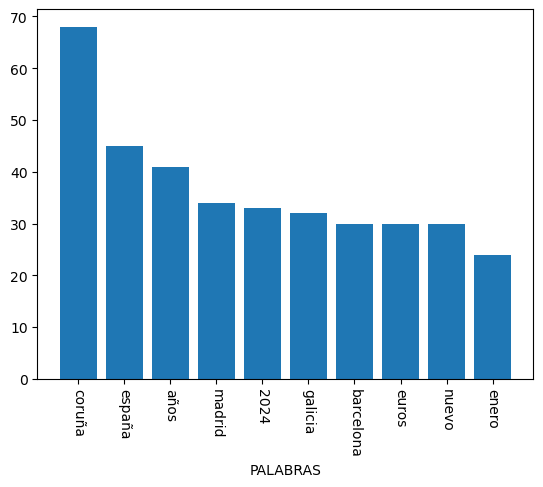

In [237]:
import matplotlib.pyplot as plt

diccionario_ordenado = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])
plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)

In [238]:
titularesOrdenados=sorted(datos,key= lambda x:x[2],reverse=True)

# Borramos si coincide titular
dicc = {}
for x in titularesOrdenados:
    dicc[x[0]] = x

titularesOrdenados = list(dicc.values())

**Librería para manejo de HTML**

In [239]:
#!conda install -y -c conda-forge airium

In [240]:
import time
from airium import Airium

a = Airium()


a('<!DOCTYPE html>')
with a.html(lang="pl"):
    with a.head():
        a.meta(charset="utf-8")
        a.title(_t="Página de noticias")
    with a.body():
        for portada in titularesOrdenados:
            with a.p(style=f"font-size:{portada[2]+1}em;"):
                with a.a(href=portada[1]):
                    a(portada[0])

html = str(a)  # casting to string extracts the value
# or directly to UTF-8 encoded bytes:
html_bytes = bytes(a)  # casting to bytes is a shortcut to str(a).encode('utf-8')

with open(f"HTML/resultado-{time.localtime().tm_year}-{time.localtime().tm_mon}-{time.localtime().tm_mday}.html","w+") as f:
    f.write(html)


In [241]:
for i in titularesOrdenados[:20]:
    print(f"URL: {i[1]} - FRASE: {i[0]}")

URL: https://elpais.com/opinion/2024-01-26/desprecio-urbanistico-en-espana.html - FRASE: Desprecio urbanístico en España
URL: https://www.elmundo.es/autor/el-mundo.html - FRASE: EL MUNDO
URL: https://www.eldiario.es//cultura/cine/tres-mujeres-acusan-cineasta-carlos-vermut-violencia-sexual_1_10868672.html - FRASE:                 Tres mujeres acusan al cineasta Carlos Vermut de “violencia sexual”    
URL: https://elpais.com/cultura/2024-01-26/tres-mujeres-acusan-al-director-de-cine-carlos-vermut-de-violencia-sexual.html - FRASE: Tres mujeres acusan al director de cine Carlos Vermut de violencia sexual
URL: https://www.elperiodico.com/es/ocio-y-cultura/20240126/tres-mujeres-acusan-violencia-sexual-director-cine-carlos-verrmut-97368008 - FRASE: Tres mujeres acusan de violencia sexual al director de cine Carlos Vermut
URL: https://www.laopinioncoruna.es/coruna/2024/01/25/lobo-marino-playa-coruna-97349764.html - FRASE: ¿Cómo actuar si aparece de nuevo el lobo marino en A Coruña?
URL: https:

In [242]:
#!conda install -y sqlite3

In [243]:
connection=None

In [244]:
import sqlite3

# Conectamos siguiendo el patrón SingleTone
if not(connection):
    connection=sqlite3.connect("Media/titulares.db")

In [245]:
cursor = connection.cursor()
try:
    cursor.execute("CREATE TABLE titulares (titular TEXT,medio TEXT, url TEXT, prelativo REAL)")
except:
    print("La tabla ya está creada")

La tabla ya está creada


In [246]:
def buscador_titular_peso(URL):
    for i in datos:
        if i[1] == URL:
            return i[0],i[2]

In [247]:
valores = []
for key,values in claves.items():
    for url in values:
        titular,peso=buscador_titular_peso(url)
        valores.append([titular,key,url,peso])


cursor.executemany("""
    INSERT INTO titulares ('titular', 'medio', 'url', 'prelativo')
    VALUES (?,?,?,?)""", valores)

In [248]:
cursor.execute("SELECT * FROM titulares order by prelativo desc")

rows = cursor.fetchall()

rows

[('Desprecio urbanístico en España',
  'El país',
  'https://elpais.com/opinion/2024-01-26/desprecio-urbanistico-en-espana.html',
  1.0),
 ('EL MUNDO',
  'El mundo',
  'https://www.elmundo.es/autor/el-mundo.html',
  0.9361702127659575),
 ('                Tres mujeres acusan al cineasta Carlos Vermut de “violencia sexual”    ',
  'El diario',
  'https://www.eldiario.es//cultura/cine/tres-mujeres-acusan-cineasta-carlos-vermut-violencia-sexual_1_10868672.html',
  0.9106382978723404),
 ('Tres mujeres acusan al director de cine Carlos Vermut de violencia sexual',
  'El país',
  'https://elpais.com/cultura/2024-01-26/tres-mujeres-acusan-al-director-de-cine-carlos-vermut-de-violencia-sexual.html',
  0.9078014184397163),
 ('Tres mujeres acusan de violencia sexual al director de cine Carlos Vermut',
  'El periódico',
  'https://www.elperiodico.com/es/ocio-y-cultura/20240126/tres-mujeres-acusan-violencia-sexual-director-cine-carlos-verrmut-97368008',
  0.9078014184397163),
 ('¿Cómo actuar si ap

In [249]:
cursor.close()
connection.close()